El código carga los primeros ficheros de "Datos_bridge_N.txt", ejecuta el código que había antes en Python, y guarda los resultados en un vector de tamaño N.

Al final se encuentra la media de cada variable X, y se presenta el Heatmap para dichas medias. A lo largo de la ejecución se pueden ver algunos intervalos de confianza y precisiones.

Al haber sólo 5 variables X, las precisión de los modelos baja bastante de 90%+ a 70%+. Esto se puede ver en el primer gráfico de las ANN.

En PLS en particular, las PLS óptimas no pueden ser 8, así que en este caso parece que, de media, entre 2 y 3 funcionan bien; así que elijo 3.

Faltan algunos archivos de datos bridge, por ejemplo el 38 lo cambio por el último, el 48 por el penultimo, y así hasta completar los 1000 si hace falta.

# Librerías

In [ ]:
# General libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Intervalos de confianza
import statistics
from scipy import stats

# Random numbers
import random

# ROC curves
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# other scikit-learn auxiliary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Importamos las librerías para trabjar con PLS y varias funciones de estadística
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from zmq import NULL

# Librearias para el KNN
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump

# Librerias para el Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import accuracy_score,classification_report,confusion_matrix
import joblib


# SHAP
!pip install shap # This is not installed by default in Google Colab
                  # Needs to be installed each time the notebook is
                  # run and it takes about 30s to do so.
import shap

# Google Drive library
from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.5 MB/s eta 0:00:00


# Preparado de datos

Los datos tienen sólo 5 columnas y están divididos en 1000 TXT; en lugar de 1 archivo para X y un archivo para Y.

In [ ]:
# Montar el disco de drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defir una función para pre-procesar cada una de las líneas de los ficheros y
# quitar el nombre de la fila.
def preprocess(row):
    return row.strip().split()[1:]

In [ ]:
# Cuantos ficheros vamos a usar, para resultados de 100 a 1000, para tests sólo 10
TOTAL_FILES = 100

# Nombre de los directorios con los ficheros
PROJECT_FOLDER = "/content/drive/My Drive/Colab Notebooks/"
DATA_FOLDER    = "datos"


# Como se llaman los ficheros, luego se añaden los números para cada archivo
BASE_NAME = "Datos_bridge_"

# Guardamos el ID de cada sensor; notice that ID 15 is not in the list
sensorNames = ["SENSOR_01", "SENSOR_02", "SENSOR_03", "SENSOR_04", "SENSOR_05"]

# Guardamos el significado de cada sensor
# En este caso de los invento
sensorProperties = ["1_MOTOR", "2_CORRIENTE", "3_AGUA", "4_PRESIÓN", "5_LUBRICANTE"]

# Cargamos los ficheros en una lista de dataframes de tamaño 1000
# El elemento i-1 (empieza en 0) de la lista equivale al fichero i (empieza en 1)

lista_de_datos_x = [None] * TOTAL_FILES
lista_de_datos_y = [None] * TOTAL_FILES


# Para cada uno de los ficheros
for i in range(TOTAL_FILES):

  nombre_completo = PROJECT_FOLDER + DATA_FOLDER + "/simulaciones/" + BASE_NAME + str(i+1) + ".txt"
  print(nombre_completo)

  # Leer el CSV
  with open(nombre_completo, 'r') as file:
      header = file.readline().strip().split()
      data = [preprocess(line) for line in file]

  # Convertir los datos preprocesados en un dataframe
  df = pd.DataFrame(data, columns=header)
  # Convertir los datos en el tipo de dato específico que hace falta
  df = df.astype({'"x1"': float, '"x2"': float, '"x3"': float, '"x4"': float, '"x5"': float, '"y"': int})
  # Cambiar el nombre de las columnas para evitar las comillas
  df.columns = ["x1", "x2", "x3", "x4", "x5", "Y"]

  # Dividimos en dataframes X e Y para que sea compatible con el código
  # que ya está hecho
  lista_de_datos_x[i] = df[['x1', 'x2', 'x3', 'x4', 'x5']]
  lista_de_datos_y[i] = df[['Y']]

print("Cargado de datos concluido")


/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Datos_bridge_1.txt
/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Datos_bridge_2.txt
/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Datos_bridge_3.txt
/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Datos_bridge_4.txt
/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Datos_bridge_5.txt
/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Datos_bridge_6.txt
/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Datos_bridge_7.txt
/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Datos_bridge_8.txt
/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Datos_bridge_9.txt
/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Datos_bridge_10.txt
/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Datos_bridge_11.txt
/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Datos_bridge_12.txt
/content/drive/My Drive/Colab Notebooks/datos/simulaciones/Da

Entrenamiento y test

In [ ]:
# Igual que antes, dividimos todo en 1000 dataframes para tests, y 1000 datasets
# para entrenamiento

# Semilla aleatoria constante para reproducibilidad
RANDOM_SEED = 42

# Declaramos la proporción de datos que son para entrenar y para testear
TRAIN_PROPORTION = 0.8 # Esto significa el 80% de los datos para el conjunto
                       # de entrenamiento y el 20% para el conjunto test

lista_de_entrenamiento_x = [None] * TOTAL_FILES
lista_de_entrenamiento_y = [None] * TOTAL_FILES
lista_de_test_x          = [None] * TOTAL_FILES
lista_de_test_y          = [None] * TOTAL_FILES



# Para cada uno de los ficheros
for i in range(TOTAL_FILES):

  # Separamos los datos en conjunto de entrenamiento y datos:
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(lista_de_datos_x[i], lista_de_datos_y[i], test_size = (1 - TRAIN_PROPORTION), random_state = RANDOM_SEED)

  # Los convertimos de vuelta a dataframes
  lista_de_entrenamiento_x[i] = pd.DataFrame(Xtrain, columns=lista_de_datos_x[i].columns)
  lista_de_test_x[i]          = pd.DataFrame(Xtest,  columns=lista_de_datos_x[i].columns)
  lista_de_entrenamiento_y[i] = pd.DataFrame(Ytrain, columns=lista_de_datos_y[i].columns)
  lista_de_test_y[i]          = pd.DataFrame(Ytest,  columns=lista_de_datos_y[i].columns)




# Guardamos las dimensiones de la matrix de entrada X para luego
totalInputsRows    = lista_de_entrenamiento_x[0].shape[0]
totalInputsColumns = lista_de_entrenamiento_x[0].shape[1]

# 1 - ANN

Comenzando a entrenar...
    Modelo A...
0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99
Entrenamiento concluido


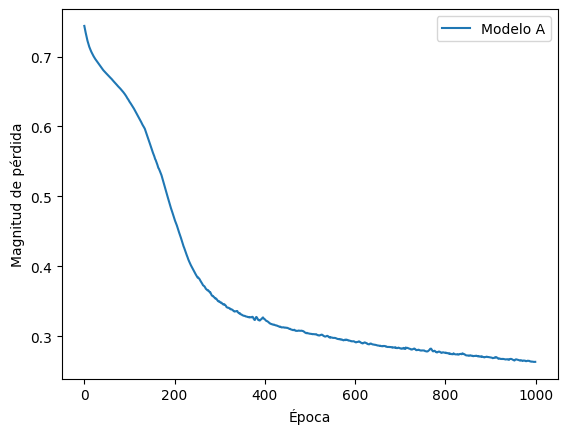

Media Predicciones: 0.8099999970197678
95% IC predicciones: (0.7953837961459891, 0.8246161978935465)


In [ ]:
# Definir cuantas entradas tiene el modelo
myInputShape     = (totalInputsColumns,)

# ------------------------------------------------------------------------------

# Usamos sólo la arquitectura A

# Para el modelo A, definimos las siguientes capas ocultas:
modeloA_ocultaA = tf.keras.layers.Dense(units = 10, input_shape = myInputShape, activation = 'relu')
modeloA_ocultaB = tf.keras.layers.Dense(units = 10, activation = 'relu')
modeloA_salida  = tf.keras.layers.Dense(units = 1,  activation = 'sigmoid')

# Creamos cada uno de los modelos
modeloA = tf.keras.Sequential([modeloA_ocultaA, modeloA_ocultaB, modeloA_salida])

# Compilamos cada uno de los modelos
modeloA.compile( optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy' )

# Entrenamos el modelo
# - Las epocas es cuantas vueltas da el modelo
# - El lote es cuantas muestras de Y usamos para entrenar el modelo cada vez
EPOCAS = 1000 # Este número hay que aumentarlo de forma considerable para que entrene bien
LOTE   = 64


# Guardamos los resultados de las pruebas aquí
lista_de_falsos_positivos     = [None] * TOTAL_FILES
lista_de_verdaderos_positivos = [None] * TOTAL_FILES
lista_de_predicciones         = [None] * TOTAL_FILES
lista_de_loss                 = [None] * TOTAL_FILES


print("Comenzando a entrenar...")

# Modelo A
print("    Modelo A...")
# Para cada uno de los ficheros
for i in range(TOTAL_FILES):

  print(i/TOTAL_FILES)
  historialA = modeloA.fit(lista_de_entrenamiento_x[i], lista_de_entrenamiento_y[i],
                           epochs = EPOCAS, batch_size = LOTE, verbose = False)



  lista_de_predicciones[i] = historialA.history['accuracy'][EPOCAS-1]

  # Evaluamos el modelo mostrando las curvas ROC para cada uno
  #modeloA_prediccion = (modeloA.predict(lista_de_test_x[i], verbose = False) > 0.5).astype(int)
  #fprA , tprA , thresholdsA = roc_curve(lista_de_test_y[i] , modeloA_prediccion)

  #lista_de_verdaderos_positivos[i] = tprA
  #lista_de_falsos_positivos[i]     = fprA


  # Nos ahorramos pintar los 1000 plots, si acaso podemos poner uno como ejemplo
  if(i == 0):

    # Pintamos la función LOSS con respecto a las épocas
    plt.xlabel("Época")
    plt.ylabel("Magnitud de pérdida")
    plt.plot(historialA.history["loss"], label='Modelo A')


# Cuando termine el entrenamiento comunicamos que está terminado
print("Entrenamiento concluido")

# Pintamos la leyenda para cada modelo y mostramos el gráfico
leg = plt.legend()
plt.show()

# Incluir intervalos bootstrap

# Monstramos las medias y CIs
#
# Medias
mean_value_pre = statistics.mean(lista_de_predicciones)
#mean_value_fpr = statistics.mean(lista_de_falsos_positivos)
#mean_value_tpr = statistics.mean(lista_de_verdaderos_positivos)
# Error standard
sem_value_pre  = stats.sem(lista_de_predicciones)
#sem_value_fpr  = stats.sem(lista_de_falsos_positivos)
#sem_value_tpr  = stats.sem(lista_de_verdaderos_positivos)
# T-score para el 95%
confidence_level = 0.95
degrees_freedom = TOTAL_FILES - 1
t_score = stats.t.ppf((1 + confidence_level) / 2, df=degrees_freedom)
# Margin de error
margin_of_error_pre = t_score * sem_value_pre
#margin_of_error_fpr = t_score * sem_value_fpr
#margin_of_error_tpr = t_score * sem_value_tpr
# 95%
confidence_interval_pre = (mean_value_pre - margin_of_error_pre, mean_value_pre + margin_of_error_pre)
#confidence_interval_fpr = (mean_value_fpr - margin_of_error_fpr, mean_value_fpr + margin_of_error_fpr)
#confidence_interval_tpr = (mean_value_tpr - margin_of_error_tpr, mean_value_tpr + margin_of_error_tpr)

# Print the results
print(f"Media Predicciones: {mean_value_pre}")
print(f"95% IC predicciones: {confidence_interval_pre}")
#print(f"Media FPR: {mean_value_fpr}")
#print(f"Media TPR: {mean_value_tpr}")
#print(f"95% Confidence Interval FPR: {confidence_interval_fpr}")
#print(f"95% Confidence Interval TPR: {confidence_interval_tpr}")


ANN - SHAP

In [ ]:
# Declaramos la paciencia que vamos a tener con respesto al cálculo del SHAP.
#
# - 10 tarda unos pocos segundos y se debe usar para comprobaciones del código.
#
# - 200 es un tamaño de muestra decente, pero tarda unas 2 horas. Este es el
#   valor que se usa para la versión final de todos los gráficos y resultados.
TOTAL_SHAP_TESTS = 10

lista_de_medias_ABSSHAPs = [None] * TOTAL_FILES

# Creamos un dataframe donde guardamos los resultados
# 5 filas, para cada una de las 5xs
# Muchas columnas, para cada uno de los ficheros de entrada
lista_de_medias_ABSSHAPs = pd.DataFrame(np.random.rand(5, TOTAL_FILES))


# Para cada uno de los ficheros
for i in range(TOTAL_FILES):

  print(i/TOTAL_FILES)

  # Transforma los datos de dataframe a matriz para poder usarlos en las
  # siguientes funciones
  XtrainNumpy = lista_de_entrenamiento_x[i].to_numpy()
  YtrainNumpy = lista_de_entrenamiento_y[i].to_numpy()
  XtestNumpy  = lista_de_test_x[i].to_numpy()
  YtestNumpy  = lista_de_test_y[i].to_numpy()

  # Usar este algorithmo con muchas muestras tarda mucho tiempo
  # Aquí pruebo a reducirlo un poco para probar los resultados iniciales

  # ---- Primero, decir cuantas veces se van a ejecutar el test. En este caso 200.
  mySamples   = shap.sample(XtestNumpy, TOTAL_SHAP_TESTS)

  # ---- Se hacen las predicciones.
  explainer    = shap.KernelExplainer(modeloA.predict,mySamples)
  shap_values2 = explainer(mySamples)

  # Creamos varios vectores donde almacenamos los valores SHAP, esto sirve para
  # poder guardar luego los resultados y no tener que esperar otras 2h si queremos
  # generar gráficos relacionados con los valores SHAP.

  vectorSHAP_valores = shap_values2.values
  vectorSHAP_base    = shap_values2.base_values
  vectorSHAP_data    = shap_values2.data

  # Guardamos también varios valores de medias y desviaciones típicas que usaremos
  # en el mapa de calor final.

  vectorMedias    = np.mean(shap_values2.values,              axis=0)
  vectorAbsMedias = np.mean(np.absolute(shap_values2.values), axis=0)
  vectorSigmas    = np.std( shap_values2.values,              axis=0)
  vectorAbsSigmas = np.std( np.absolute(shap_values2.values), axis=0)

  # Guardamos las super-medias
  lista_de_medias_ABSSHAPs.iloc[:, i] = vectorAbsMedias.flatten()  # Flatten the array to match the DataFrame's shape

# Calculamos las medias de cada variable
row_averages_ANN = lista_de_medias_ABSSHAPs.mean(axis=1).tolist()
print(row_averages_ANN)



0.0
1/1 [==============================] - 0s 107ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.01
1/1 [==============================] - 0s 22ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.02
1/1 [==============================] - 0s 21ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.03
1/1 [==============================] - 0s 25ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.04
1/1 [==============================] - 0s 24ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.05
1/1 [==============================] - 0s 34ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.06
1/1 [==============================] - 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.07
1/1 [==============================] - 0s 23ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.08
1/1 [==============================] - 0s 22ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.09
1/1 [==============================] - 0s 25ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
0.1
1/1 [==============================] - 0s 35ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.11
1/1 [==============================] - 0s 33ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.12
1/1 [==============================] - 0s 24ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.13
1/1 [==============================] - 0s 22ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.14
1/1 [==============================] - 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.15
1/1 [==============================] - 0s 31ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.16
1/1 [==============================] - 0s 27ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.17
1/1 [==============================] - 0s 32ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.18
1/1 [==============================] - 0s 32ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.19
1/1 [==============================] - 0s 32ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.2
1/1 [==============================] - 0s 38ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.21
1/1 [==============================] - 0s 22ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.22
1/1 [==============================] - 0s 25ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.23
1/1 [==============================] - 0s 24ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.24
1/1 [==============================] - 0s 25ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.25
1/1 [==============================] - 0s 32ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.26
1/1 [==============================] - 0s 23ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.27
1/1 [==============================] - 0s 23ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.28
1/1 [==============================] - 0s 23ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.29
1/1 [==============================] - 0s 25ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.3
1/1 [==============================] - 0s 37ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
0.31
1/1 [==============================] - 0s 35ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.32
1/1 [==============================] - 0s 25ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.33
1/1 [==============================] - 0s 23ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.34
1/1 [==============================] - 0s 29ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.35
1/1 [==============================] - 0s 24ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.36
1/1 [==============================] - 0s 43ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.37
1/1 [==============================] - 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.38
1/1 [==============================] - 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.39
1/1 [==============================] - 0s 72ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
0.4
1/1 [==============================] - 0s 47ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
0.41
1/1 [==============================] - 0s 40ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.42
1/1 [==============================] - 0s 40ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.43
1/1 [==============================] - 0s 35ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.44
1/1 [==============================] - 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.45
1/1 [==============================] - 0s 25ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.46
1/1 [==============================] - 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.47
1/1 [==============================] - 0s 29ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
0.48
1/1 [==============================] - 0s 50ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.49
1/1 [==============================] - 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.5
1/1 [==============================] - 0s 29ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.51
1/1 [==============================] - 0s 23ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.52
1/1 [==============================] - 0s 22ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.53
1/1 [==============================] - 0s 35ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.54
1/1 [==============================] - 0s 24ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.55
1/1 [==============================] - 0s 25ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.56
1/1 [==============================] - 0s 29ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.57
1/1 [==============================] - 0s 27ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.58
1/1 [==============================] - 0s 30ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.59
1/1 [==============================] - 0s 21ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.6
1/1 [==============================] - 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.61
1/1 [==============================] - 0s 27ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.62
1/1 [==============================] - 0s 22ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.63
1/1 [==============================] - 0s 33ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.64
1/1 [==============================] - 0s 29ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.65
1/1 [==============================] - 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.66
1/1 [==============================] - 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.67
1/1 [==============================] - 0s 21ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
0.68
1/1 [==============================] - 0s 31ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.69
1/1 [==============================] - 0s 24ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.7
1/1 [==============================] - 0s 28ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.71
1/1 [==============================] - 0s 36ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.72
1/1 [==============================] - 0s 27ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
0.73
1/1 [==============================] - 0s 54ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
0.74
1/1 [==============================] - 0s 39ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.75
1/1 [==============================] - 0s 40ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.76
1/1 [==============================] - 0s 29ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
0.77
1/1 [==============================] - 0s 41ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.78
1/1 [==============================] - 0s 28ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.79
1/1 [==============================] - 0s 73ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 8ms/step
0.8
1/1 [==============================] - 0s 89ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 8ms/step
0.81
1/1 [==============================] - 0s 123ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
0.82
1/1 [==============================] - 0s 38ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.83
1/1 [==============================] - 0s 37ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
0.84
1/1 [==============================] - 0s 50ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 7ms/step
0.85
1/1 [==============================] - 0s 87ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.86
1/1 [==============================] - 0s 43ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.87
1/1 [==============================] - 0s 49ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
0.88
1/1 [==============================] - 0s 47ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.89
1/1 [==============================] - 0s 23ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.9
1/1 [==============================] - 0s 24ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.91
1/1 [==============================] - 0s 27ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
0.92
1/1 [==============================] - 0s 25ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 9ms/step
0.93
1/1 [==============================] - 0s 77ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step
0.94
1/1 [==============================] - 0s 89ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.95
1/1 [==============================] - 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.96
1/1 [==============================] - 0s 23ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 4ms/step
0.97
1/1 [==============================] - 0s 43ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.98
1/1 [==============================] - 0s 26ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step
0.99
1/1 [==============================] - 0s 24ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step
[0.07862871136030218, 0.09797510028830256, 0.017645630125890075, 0.05215466722159857, 0.056143262164411505]


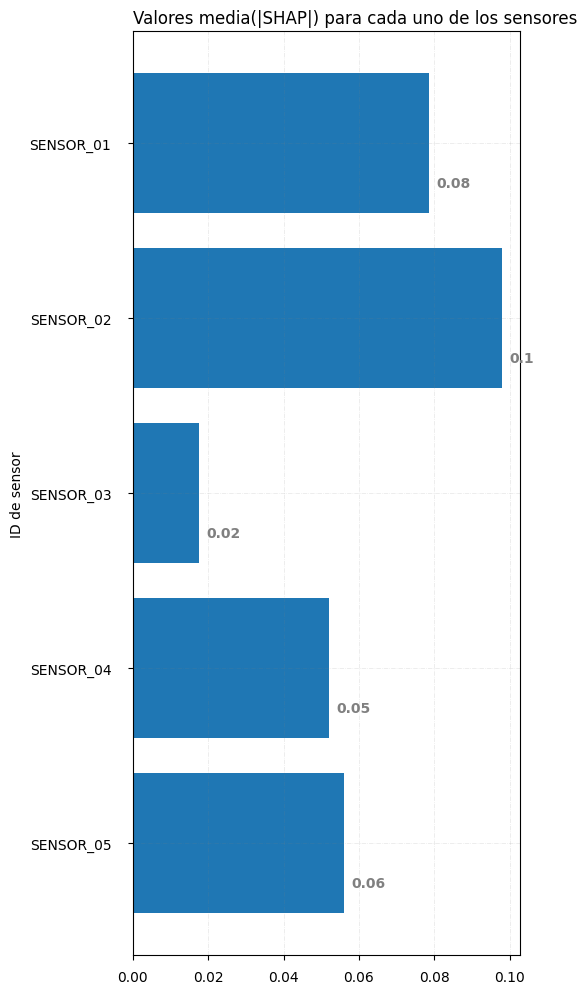

In [ ]:
# Mostrar el gráfico

# Este comando es lo mismo, pero sólo muestra los 20 primeros, para mantener consistencia muestro los 50 sensores.
# shap.summary_plot( shap_values , mySamples, feature_names = list(Xtrain.columns) )

variablesNames = list(Xtrain.columns)
currentPlotTitle = 'Valores media(|SHAP|) para cada uno de los sensores'

# Create the plot dataframe

#barplotData = np.zeros((200, 50))
barplotData = pd.DataFrame( np.zeros([len(sensorNames),2]) , columns = ['name', 'value'] )
barplotData.iloc[:,0] = sensorNames
barplotData.iloc[:,1] = row_averages_ANN

# Figure Size
fig, ax = plt.subplots(figsize=(5, 12))

# Horizontal Bar Plot
plt.barh(barplotData.iloc[:,0],  barplotData.iloc[:,1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 7 )
ax.yaxis.set_tick_params(pad = 12)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show first values on top
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

  currentOffset = 0.002
  currentW = i.get_width()
  if(currentW < 0): currentOffset = -0.005

  plt.text(i.get_width() + currentOffset, i.get_y() + 0.65,
           str(round((i.get_width()), 2)),
           fontsize=10, fontweight='bold',
           color='grey')


# Add Plot Title
ax.set_title(currentPlotTitle,loc='left', )
ax.set_ylabel("ID de sensor")

# Show Plot
plt.show()

Guardamos los datos

In [ ]:
# Nombre del fichero y directorio donde se guarda
ANN_SHAPS             = 'ANN_SHAPS_'            + str(TOTAL_FILES) + '.csv'
ANN_AVERAGE_VALUES    = 'ANN_averageValues_'    + str(TOTAL_FILES) + '.txt'
ANN_PREDICTION_VALUES = 'ANN_predictionValues_' + str(TOTAL_FILES) + '.txt'

BASE_FOLDER = PROJECT_FOLDER + 'Resultados/Simulaciones/'

# Guardar el resultado para que luego se pueda hacer el heatmap
lista_de_medias_ABSSHAPs.to_csv( BASE_FOLDER + ANN_SHAPS, index=False)
np.savetxt(BASE_FOLDER + ANN_AVERAGE_VALUES, row_averages_ANN)
np.savetxt(BASE_FOLDER + ANN_PREDICTION_VALUES, lista_de_predicciones)



# 2 - PLS

In [ ]:
# Normalizamos las matrices X e Y. En nuestro caso ya están centradas y ninguna
# variable parace tener una escala diferente al resto que pueda afectar a la
# variabilidad, pero lo dejamos hecho por si acaso.

lista_normalizada_x = [None] * TOTAL_FILES
lista_normalizada_y = [None] * TOTAL_FILES

for i in range(TOTAL_FILES):

  Xnorm = lista_de_datos_x[i] - lista_de_datos_x[i].mean()
  lista_normalizada_x[i] = Xnorm / Xnorm.max()
  Ynorm = lista_de_datos_y[i] - lista_de_datos_y[i].mean()
  lista_normalizada_y[i] = Ynorm / Ynorm.max()

In [ ]:
# Definimos una función que va a probar la misma función de PLSR para diferentes
# cantitades de componenetes. PLSR nos va a devolver el error cuadrado medio (MSE)
# para número de componentes que le digamos. Eso lo guardamos en un vector, y
# nos quedamos con el número de componentes que hace MSE mínimo.

# Al igual que en PCA, estó va a presentar un scree-plot. Aunque el MSE sea
# mínimo para un número de componentes determinado, es posible que sea más
# interesante usar un número de componentes distinto al mínimo si no hay mucha
# diferencia con respecto al MSE para ese número de componentes.

def optimise_pls_cv(X, Y, n_comp, plot_components=True):

    # Guardamos cual es el MSE minimo y el mejor modelo posible.
    #
    # Inicializamos el mejor resultado a MSE = 9999 y número de componentes
    # mayor al número total de variables que tenemos. Este es un resultado
    # imposible y está programado así a drede.
    #
    # Así forzamos a que la primera opción mejore el mejor resultado de
    # inicialización y no hace falta hacer casos especiales dentro del bucle.
    mse_minimo        = 99999
    mejor_componentes = n_comp + 10
    mejor_modelo_pls  = NULL
    mejor_validacion  = NULL

    # Guardamos todos los MSE aquí.
    mse = []

    # Generamos un vector con cada una de las cantidades de componentes posibles
    component = np.arange(1, n_comp)

    # Para componente, hacemos PLSR y encontramos el MSE
    for i in component:

        # Hacemos PLS
        modelo_pls_actual = PLSRegression(n_components = i)

        # Hacemos validación cruzada para ver que tal se comporta el modelo
        #
        # ---- Calculamos los Ŷ
        #
        #      El número por defecto para hacer la validación cruzada es 5,
        #      yo aquí le he puesto 10 sin ningún motivo en especial.
        #
        y_cv = cross_val_predict(modelo_pls_actual, X, Y, cv = 10)

        # ---- Hayamos MSE
        mse_actual = mean_squared_error(Y, y_cv)
        mse.append(mse_actual)
        #
        # comp = 100 * ( i + 1) / n_comp

        # Actualizamos el mejor modelo posible si encontramos uno mejor
        if(mse_minimo > mse_actual):
            mse_minimo        = mse_actual
            mejor_componentes = i
            mejor_modelo_pls  = modelo_pls_actual
            mejor_validacion  = y_cv


    # Indicamos cual ha sido el mejor número de componentes
    print("Sugerimos usar este número de componentes: ", mejor_componentes)

    # Opcionalmente, podemos enseñar la gráfica con los valores de MSE
    if (plot_components):
        with plt.style.context(('ggplot')):
             plt.plot( component,         np.array(mse), '-v', color = 'blue', mfc = 'blue')
             plt.plot( mejor_componentes, mse_minimo,    'P', ms = 10, mfc = 'red')
             plt.xlabel('Número de componentes PLS')
             plt.ylabel('MSE')
             plt.title('PLS')
             plt.xlim(left=-1)

        #plt.show()


    # Ajustamos los datos al mejor modelo encontrado
    mejor_modelo_pls.fit(X, Y)
    y_c = mejor_modelo_pls.predict(X)

    # Calculamos los valores de R2 para calibración y validación cruzada (cross-validation ; cv)
    score_c  = r2_score(Y, y_c)
    score_cv = r2_score(Y, mejor_validacion)

    # Calculamos el MSE para calibración y validación cruzada
    mse_c  = mean_squared_error(Y, y_c)
    mse_cv = mean_squared_error(Y, mejor_validacion)

    print('R2 calib:'  + str(score_c))
    print('R2 CV:'     + str(score_cv))
    print('MSE calib:' + str(mse_c))
    print('MSE CV:'    + str(mse_cv))

    # Plot regression and figures of merit
    rangey = max(Y) - min(Y)
    rangex = max(y_c) - min(y_c)

    # Fit a line to the CV vs response
    z = np.polyfit(Y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, Y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,Y), Y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(Y, Y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted')
        plt.ylabel('Measured')

    #plt.show()

    print("Número óptimo de componentes:")
    print(mejor_componentes)


    return mejor_componentes

Con sólo 5 variables es difícil decidir el número óptimo. Parece que 2 o 3 es el ideal. Pero 3, es casi el 60% de las variables, así que no tiene sentido extrapolar a 50 sensores y pedirle al PLS que funcione con 30 sensores porque con unos pocos funcionaría bien.

In [ ]:
for i in range(TOTAL_FILES):

  optimise_pls_cv(lista_normalizada_x[i],lista_normalizada_y[i].squeeze(),
                  totalInputsColumns , plot_components= False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Semilla aleatoria constante para reproducibilidad
# En este caso no se usa semilla, o de lo contrario los 200 resultados serían
# el mismo con una sigma = 0.

TOTAL_TESTS  = 200
plsSuperData        = [None] * TOTAL_FILES
fiabilidadSuperData = [None] * TOTAL_FILES

# Creamos un dataframe donde guardamos los resultados
# 5 filas, para cada una de las 5xs
# Muchas columnas, para cada uno de los ficheros de entrada
lista_de_coeficientes = pd.DataFrame(np.random.rand(5, TOTAL_FILES))


# Para cada archivo usamos los TOTAL_TEST
# Osea que hay un montón de tests
for k in range(TOTAL_FILES):

  print(k/TOTAL_FILES)

  # Inicializamos una variable donde guardaremos los datos de pesos de los coeficientes
  plsData = np.zeros((TOTAL_TESTS, totalInputsColumns))

  # Generamos un vector donde guardamos las fiabilidades
  vectorFiabilidades = np.zeros(TOTAL_TESTS)

  # Copio los datos que tenemos en otros dataframes por si acaso se modifican
  df_x = pd.DataFrame(lista_de_datos_x[k])
  df_y = pd.DataFrame(lista_de_datos_y[k].squeeze())

  # Para cada modelo, generamos una fiabilidad distinta
  # Usamos 200 iteraciones para que coincida con las iteraciones del SHAP
  for j in range(0,200):

    # Creamos el modelo PLS
    pls2 = PLSRegression(n_components = 3)

    # Ajustar el modelo
    pls2.fit(lista_de_entrenamiento_x[k], lista_de_entrenamiento_y[k])

    # Predecir valores
    Y_pred = pls2.predict(Xtest)
    Y_addjusted = Y_pred.copy()


    # Guardamos los coeficientes
    pl2Coeficientes = pls2.coef_

    # Guardamos las super-medias
    lista_de_coeficientes.iloc[:, k] = pl2Coeficientes.flatten()


    # Los Ys se predicen por una función que dará un resultado continuo
    # Así que aquí se convierten los datos en lo que tenga más cerca cada uno
    # Convertir los Y_pred en 0s si es menor que 0.5, y al contrario para 1s
    for i in range(0,Y_pred.shape[0]):
      if(Y_addjusted[i] < 0.5): Y_addjusted[i] = 0
      else: Y_addjusted[i] = 1

    # Comparamos las predicciones con el conjunto del test
    predicciones = Y_addjusted == Ytest
    fiabilidad   = sum(predicciones['Y'])/Y_pred.shape[0]

    # Lo guardamos en el vector grande
    vectorFiabilidades[j] = fiabilidad

    # Igual que antes, guardamos los resultados para el vector de medias y sigmas
    plsData[j] = np.squeeze(pls2.coef_)


  fiabilidadSuperData[k] = np.mean(vectorFiabilidades)
  #print(np.std(vectorFiabilidades))


print(np.mean(fiabilidadSuperData))

# Calculamos las medias de cada variable
row_averages_PLS = lista_de_coeficientes.mean(axis=1).tolist()
print(row_averages_PLS)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape o

0.7150000000000002
[0.12242772946037228, 0.11729478397137111, 0.03177432027173822, 0.12607041349313727, 0.12464011623914681]


/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will

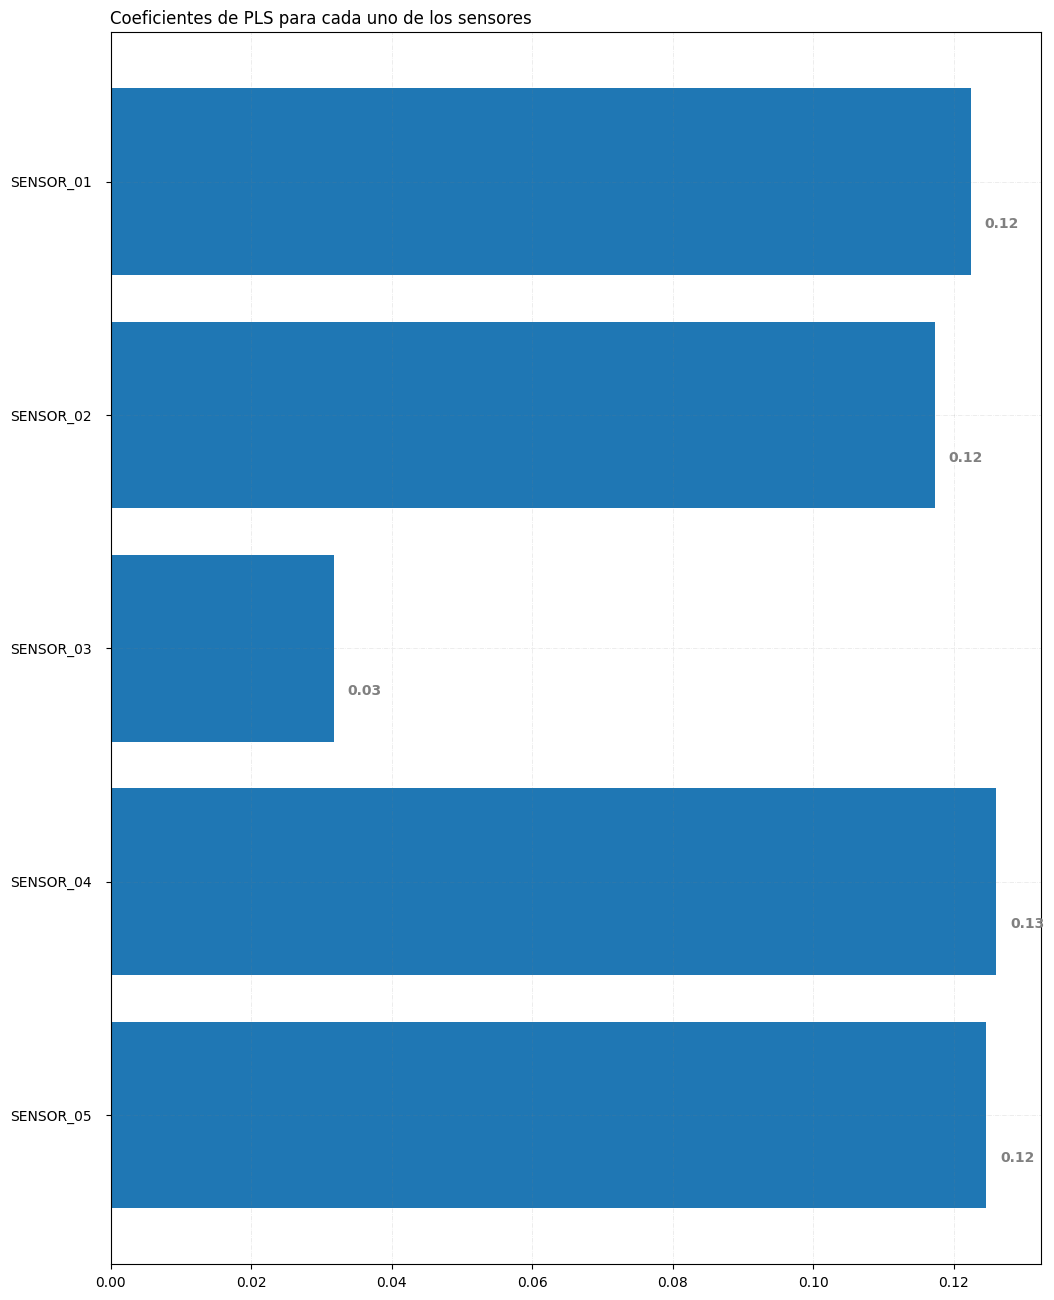

In [ ]:
# Usamos el último modelo generado para este gráfico. En la tabla final vermos
# las medias de todos los valores de todos los sensores de todos los métodos.
barplotData = pd.DataFrame( np.zeros([len(pls2.coef_),2]) )
barplotData[0] = sensorNames
barplotData[1] = row_averages_PLS

# Figure Size
fig, ax = plt.subplots(figsize=(12, 16))

# Horizontal Bar Plot
plt.barh(barplotData[0], barplotData[1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

    currentOffset = 0.002
    currentW = i.get_width()
    if(currentW < 0): currentOffset = -0.005

    plt.text(i.get_width() + currentOffset, i.get_y() + 0.6,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Coeficientes de PLS para cada uno de los sensores',
             loc='left', )

# Show Plot
plt.show()

Guardamos los datos

In [ ]:
# Nombre del fichero y directorio donde se guarda
PLS_SHAPS             = 'PLS_Pesos_'            + str(TOTAL_FILES) + '.csv'
PLS_AVERAGE_VALUES    = 'PLS_averageValues_'    + str(TOTAL_FILES) + '.txt'
PLS_PREDICTION_VALUES = 'PLS_predictionValues_' + str(TOTAL_FILES) + '.txt'

BASE_FOLDER = PROJECT_FOLDER + 'Resultados/Simulaciones/'

# Guardar el resultado para que luego se pueda hacer el heatmap
lista_de_coeficientes.to_csv( BASE_FOLDER + PLS_SHAPS, index=False)
np.savetxt(BASE_FOLDER + PLS_AVERAGE_VALUES, row_averages_PLS)
np.savetxt(BASE_FOLDER + PLS_PREDICTION_VALUES, fiabilidadSuperData)

3 - KNN

In [ ]:
# Creamos el modelo KNN
knn = KNeighborsClassifier(n_neighbors = 4)

lista_de_knn_scores = [None] * TOTAL_FILES

for i in range(TOTAL_FILES):

  # Ajustar el modelo
  knn.fit(lista_de_entrenamiento_x[i], lista_de_entrenamiento_y[i].squeeze())
  lista_de_knn_scores[i] = knn.score(lista_de_test_x[i], lista_de_test_y[i].squeeze())

media_knn = statistics.mean(lista_de_knn_scores)
print(media_knn)

0.6995


In [ ]:
# Declaramos la paciencia que vamos a tener con respesto al cálculo del SHAP.
#
# - 10 tarda unos pocos segundos y se debe usar para comprobaciones del código.
#
# - 200 es un tamaño de muestra decente, pero tarda unas 2 horas. Este es el
#   valor que se usa para la versión final de todos los gráficos y resultados.
TOTAL_SHAP_TESTS = 10

lista_de_medias_ABSSHAPs = [None] * TOTAL_FILES

# Creamos un dataframe donde guardamos los resultados
# 5 filas, para cada una de las 5xs
# Muchas columnas, para cada uno de los ficheros de entrada
lista_de_medias_ABSSHAPs = pd.DataFrame(np.random.rand(5, TOTAL_FILES))


# Para cada uno de los ficheros
for i in range(TOTAL_FILES):

  print(i/TOTAL_FILES)

  # Transforma los datos de dataframe a matriz para poder usarlos en las
  # siguientes funciones
  XtrainNumpy = lista_de_entrenamiento_x[i].to_numpy()
  YtrainNumpy = lista_de_entrenamiento_y[i].to_numpy()
  XtestNumpy  = lista_de_test_x[i].to_numpy()
  YtestNumpy  = lista_de_test_y[i].to_numpy()

  # Usar este algorithmo con muchas muestras tarda mucho tiempo
  # Aquí pruebo a reducirlo un poco para probar los resultados iniciales

  # ---- Primero, decir cuantas veces se van a ejecutar el test. En este caso 200.
  mySamples   = shap.sample(XtestNumpy, TOTAL_SHAP_TESTS)


  # ---- Se hacen las predicciones.
  #explainer    = shap.KernelExplainer(modeloA.predict,mySamples)
  #shap_values2 = explainer(mySamples)


  # ---- Se hacen las predicciones.
  explainer    = shap.KernelExplainer(knn.predict,mySamples)
  shap_values2 = explainer(mySamples)


  # Creamos varios vectores donde almacenamos los valores SHAP, esto sirve para
  # poder guardar luego los resultados y no tener que esperar otras 2h si queremos
  # generar gráficos relacionados con los valores SHAP.

  vectorSHAP_valores = shap_values2.values
  vectorSHAP_base    = shap_values2.base_values
  vectorSHAP_data    = shap_values2.data

  # Guardamos también varios valores de medias y desviaciones típicas que usaremos
  # en el mapa de calor final.

  vectorMedias    = np.mean(shap_values2.values,              axis=0)
  vectorAbsMedias = np.mean(np.absolute(shap_values2.values), axis=0)
  vectorSigmas    = np.std( shap_values2.values,              axis=0)
  vectorAbsSigmas = np.std( np.absolute(shap_values2.values), axis=0)

  # Guardamos las super-medias
  lista_de_medias_ABSSHAPs.iloc[:, i] = vectorAbsMedias.flatten()  # Flatten the array to match the DataFrame's shape

# Calculamos las medias de cada variable
row_averages_KNN = lista_de_medias_ABSSHAPs.mean(axis=1).tolist()
print(row_averages_KNN)



0.0


  0%|          | 0/10 [00:00<?, ?it/s]

0.01


  0%|          | 0/10 [00:00<?, ?it/s]

0.02


  0%|          | 0/10 [00:00<?, ?it/s]

0.03


  0%|          | 0/10 [00:00<?, ?it/s]

0.04


  0%|          | 0/10 [00:00<?, ?it/s]

0.05


  0%|          | 0/10 [00:00<?, ?it/s]

0.06


  0%|          | 0/10 [00:00<?, ?it/s]

0.07


  0%|          | 0/10 [00:00<?, ?it/s]

0.08


  0%|          | 0/10 [00:00<?, ?it/s]

0.09


  0%|          | 0/10 [00:00<?, ?it/s]

0.1


  0%|          | 0/10 [00:00<?, ?it/s]

0.11


  0%|          | 0/10 [00:00<?, ?it/s]

0.12


  0%|          | 0/10 [00:00<?, ?it/s]

0.13


  0%|          | 0/10 [00:00<?, ?it/s]

0.14


  0%|          | 0/10 [00:00<?, ?it/s]

0.15


  0%|          | 0/10 [00:00<?, ?it/s]

0.16


  0%|          | 0/10 [00:00<?, ?it/s]

0.17


  0%|          | 0/10 [00:00<?, ?it/s]

0.18


  0%|          | 0/10 [00:00<?, ?it/s]

0.19


  0%|          | 0/10 [00:00<?, ?it/s]

0.2


  0%|          | 0/10 [00:00<?, ?it/s]

0.21


  0%|          | 0/10 [00:00<?, ?it/s]

0.22


  0%|          | 0/10 [00:00<?, ?it/s]

0.23


  0%|          | 0/10 [00:00<?, ?it/s]

0.24


  0%|          | 0/10 [00:00<?, ?it/s]

0.25


  0%|          | 0/10 [00:00<?, ?it/s]

0.26


  0%|          | 0/10 [00:00<?, ?it/s]

0.27


  0%|          | 0/10 [00:00<?, ?it/s]

0.28


  0%|          | 0/10 [00:00<?, ?it/s]

0.29


  0%|          | 0/10 [00:00<?, ?it/s]

0.3


  0%|          | 0/10 [00:00<?, ?it/s]

0.31


  0%|          | 0/10 [00:00<?, ?it/s]

0.32


  0%|          | 0/10 [00:00<?, ?it/s]

0.33


  0%|          | 0/10 [00:00<?, ?it/s]

0.34


  0%|          | 0/10 [00:00<?, ?it/s]

0.35


  0%|          | 0/10 [00:00<?, ?it/s]

0.36


  0%|          | 0/10 [00:00<?, ?it/s]

0.37


  0%|          | 0/10 [00:00<?, ?it/s]

0.38


  0%|          | 0/10 [00:00<?, ?it/s]

0.39


  0%|          | 0/10 [00:00<?, ?it/s]

0.4


  0%|          | 0/10 [00:00<?, ?it/s]

0.41


  0%|          | 0/10 [00:00<?, ?it/s]

0.42


  0%|          | 0/10 [00:00<?, ?it/s]

0.43


  0%|          | 0/10 [00:00<?, ?it/s]

0.44


  0%|          | 0/10 [00:00<?, ?it/s]

0.45


  0%|          | 0/10 [00:00<?, ?it/s]

0.46


  0%|          | 0/10 [00:00<?, ?it/s]

0.47


  0%|          | 0/10 [00:00<?, ?it/s]

0.48


  0%|          | 0/10 [00:00<?, ?it/s]

0.49


  0%|          | 0/10 [00:00<?, ?it/s]

0.5


  0%|          | 0/10 [00:00<?, ?it/s]

0.51


  0%|          | 0/10 [00:00<?, ?it/s]

0.52


  0%|          | 0/10 [00:00<?, ?it/s]

0.53


  0%|          | 0/10 [00:00<?, ?it/s]

0.54


  0%|          | 0/10 [00:00<?, ?it/s]

0.55


  0%|          | 0/10 [00:00<?, ?it/s]

0.56


  0%|          | 0/10 [00:00<?, ?it/s]

0.57


  0%|          | 0/10 [00:00<?, ?it/s]

0.58


  0%|          | 0/10 [00:00<?, ?it/s]

0.59


  0%|          | 0/10 [00:00<?, ?it/s]

0.6


  0%|          | 0/10 [00:00<?, ?it/s]

0.61


  0%|          | 0/10 [00:00<?, ?it/s]

0.62


  0%|          | 0/10 [00:00<?, ?it/s]

0.63


  0%|          | 0/10 [00:00<?, ?it/s]

0.64


  0%|          | 0/10 [00:00<?, ?it/s]

0.65


  0%|          | 0/10 [00:00<?, ?it/s]

0.66


  0%|          | 0/10 [00:00<?, ?it/s]

0.67


  0%|          | 0/10 [00:00<?, ?it/s]

0.68


  0%|          | 0/10 [00:00<?, ?it/s]

0.69


  0%|          | 0/10 [00:00<?, ?it/s]

0.7


  0%|          | 0/10 [00:00<?, ?it/s]

0.71


  0%|          | 0/10 [00:00<?, ?it/s]

0.72


  0%|          | 0/10 [00:00<?, ?it/s]

0.73


  0%|          | 0/10 [00:00<?, ?it/s]

0.74


  0%|          | 0/10 [00:00<?, ?it/s]

0.75


  0%|          | 0/10 [00:00<?, ?it/s]

0.76


  0%|          | 0/10 [00:00<?, ?it/s]

0.77


  0%|          | 0/10 [00:00<?, ?it/s]

0.78


  0%|          | 0/10 [00:00<?, ?it/s]

0.79


  0%|          | 0/10 [00:00<?, ?it/s]

0.8


  0%|          | 0/10 [00:00<?, ?it/s]

0.81


  0%|          | 0/10 [00:00<?, ?it/s]

0.82


  0%|          | 0/10 [00:00<?, ?it/s]

0.83


  0%|          | 0/10 [00:00<?, ?it/s]

0.84


  0%|          | 0/10 [00:00<?, ?it/s]

0.85


  0%|          | 0/10 [00:00<?, ?it/s]

0.86


  0%|          | 0/10 [00:00<?, ?it/s]

0.87


  0%|          | 0/10 [00:00<?, ?it/s]

0.88


  0%|          | 0/10 [00:00<?, ?it/s]

0.89


  0%|          | 0/10 [00:00<?, ?it/s]

0.9


  0%|          | 0/10 [00:00<?, ?it/s]

0.91


  0%|          | 0/10 [00:00<?, ?it/s]

0.92


  0%|          | 0/10 [00:00<?, ?it/s]

0.93


  0%|          | 0/10 [00:00<?, ?it/s]

0.94


  0%|          | 0/10 [00:00<?, ?it/s]

0.95


  0%|          | 0/10 [00:00<?, ?it/s]

0.96


  0%|          | 0/10 [00:00<?, ?it/s]

0.97


  0%|          | 0/10 [00:00<?, ?it/s]

0.98


  0%|          | 0/10 [00:00<?, ?it/s]

0.99


  0%|          | 0/10 [00:00<?, ?it/s]

[0.15386666666666657, 0.17710333333333317, 0.10354999999999992, 0.10334999999999991, 0.09877666666666667]


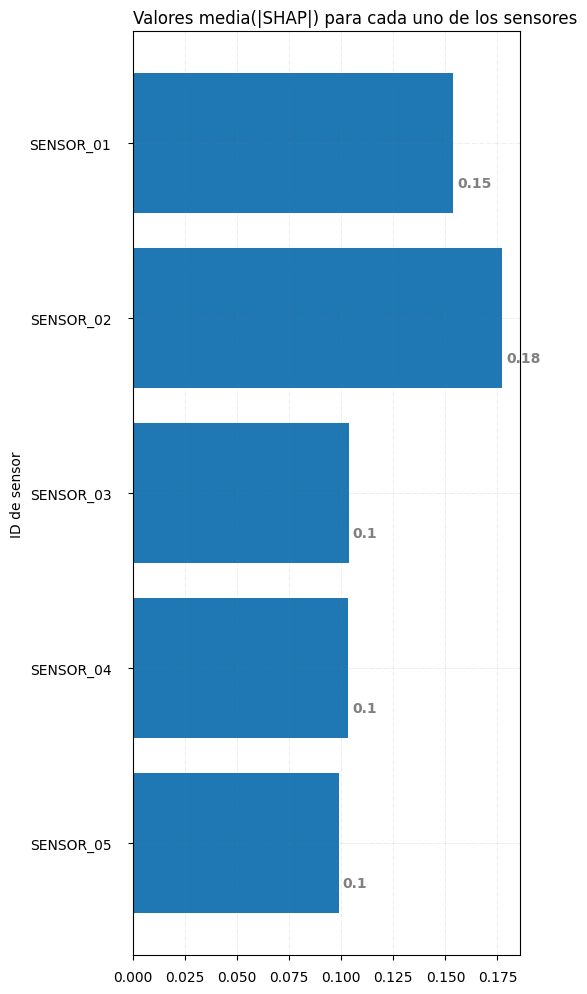

In [ ]:
# Mostrar el gráfico

# Este comando es lo mismo, pero sólo muestra los 20 primeros, para mantener consistencia muestro los 50 sensores.
# shap.summary_plot( shap_values , mySamples, feature_names = list(Xtrain.columns) )

variablesNames = list(Xtrain.columns)
currentPlotTitle = 'Valores media(|SHAP|) para cada uno de los sensores'

# Create the plot dataframe

#barplotData = np.zeros((200, 50))
barplotData = pd.DataFrame( np.zeros([len(sensorNames),2]) , columns = ['name', 'value'] )
barplotData.iloc[:,0] = sensorNames
barplotData.iloc[:,1] = row_averages_KNN

# Figure Size
fig, ax = plt.subplots(figsize=(5, 12))

# Horizontal Bar Plot
plt.barh(barplotData.iloc[:,0],  barplotData.iloc[:,1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 7 )
ax.yaxis.set_tick_params(pad = 12)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show first values on top
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

  currentOffset = 0.002
  currentW = i.get_width()
  if(currentW < 0): currentOffset = -0.005

  plt.text(i.get_width() + currentOffset, i.get_y() + 0.65,
           str(round((i.get_width()), 2)),
           fontsize=10, fontweight='bold',
           color='grey')


# Add Plot Title
ax.set_title(currentPlotTitle,loc='left', )
ax.set_ylabel("ID de sensor")

# Show Plot
plt.show()

Guardamos los datos

In [ ]:
# Nombre del fichero y directorio donde se guarda
KNN_SHAPS             = 'KNN_Pesos_'            + str(TOTAL_FILES) + '.csv'
KNN_AVERAGE_VALUES    = 'KNN_averageValues_'    + str(TOTAL_FILES) + '.txt'
KNN_PREDICTION_VALUES = 'KNN_predictionValues_' + str(TOTAL_FILES) + '.txt'

BASE_FOLDER = PROJECT_FOLDER + 'Resultados/Simulaciones/'

# Guardar el resultado para que luego se pueda hacer el heatmap
lista_de_medias_ABSSHAPs.to_csv( BASE_FOLDER + KNN_SHAPS, index=False)
np.savetxt(BASE_FOLDER + KNN_AVERAGE_VALUES, row_averages_KNN)
np.savetxt(BASE_FOLDER + KNN_PREDICTION_VALUES, lista_de_knn_scores)

# 4 - RF

In [ ]:
# Creamos el modelo RF
randomforest = RandomForestClassifier(criterion='entropy')

# Guardamos los MDI aquí
lista_de_medias_RFMDI = [None] * TOTAL_FILES
lista_de_medias_RFMDI = pd.DataFrame(np.random.rand(5, TOTAL_FILES))
# Guardamos los SHAP aquí
lista_de_medias_RFSHAP = [None] * TOTAL_FILES
lista_de_medias_RFSHAP = pd.DataFrame(np.random.rand(5, TOTAL_FILES))


lista_de_RF_scores = [None] * TOTAL_FILES

for i in range(TOTAL_FILES):

  randomforest.fit(lista_de_entrenamiento_x[i], lista_de_entrenamiento_y[i].squeeze())
  y_predict = randomforest.predict(lista_de_test_x[i])

  # Predicciones
  lista_de_RF_scores[i] = accuracy_score(lista_de_test_y[i].squeeze(),y_predict)

  # MDI
  lista_de_medias_RFMDI.iloc[:, i] = randomforest.feature_importances_.flatten()

  # SHAP
  explainerRF   = shap.Explainer(randomforest, lista_de_entrenamiento_x[i])
  shap_valuesRF = explainerRF(lista_de_test_x[i], check_additivity=False)

  # Extraemos los elementos izquierdos y derechos de los valores SHAPs
  # (el shap para el random forest es un tanto confuso)
  left_list  = [[item[0] for item in sublist] for sublist in shap_valuesRF.values]
  right_list = [[item[1] for item in sublist] for sublist in shap_valuesRF.values]

  # Inicializamos el vector de base (todos los números son iguales)
  base_data = np.random.rand(len(left_list))
  for k in range(len(base_data)):
    base_data[k] = shap_valuesRF[0].base_values[0]

  # Creamos varios vectores donde almacenamos los valores SHAP
  vectorSHAP_valores = left_list
  vectorSHAP_base    = base_data
  vectorSHAP_data    = shap_valuesRF.data

  # Guardamos también varios valores de medias y desviaciones típicas que usaremos
  # en el mapa de calor final.
  lista_de_medias_RFSHAP[i] = np.mean(np.absolute(vectorSHAP_valores), axis=0).flatten()


media_RF = statistics.mean(lista_de_RF_scores)
print(media_RF)

# Calculamos las medias de cada variable
row_averages_RFMDI = lista_de_medias_RFMDI.mean(axis=1).tolist()
print(row_averages_RFMDI)

# Calculamos las medias de cada variable
row_averages_RFSHAP = lista_de_medias_RFSHAP.mean(axis=1).tolist()
print(row_averages_RFSHAP)

0.6955
[0.2084854874459722, 0.20957669813229787, 0.15638570713627498, 0.21302769650851178, 0.21252441077694317]
[0.09113911368908521, 0.09129359386238318, 0.04192164400178372, 0.09171793967238122, 0.09083575638339862]


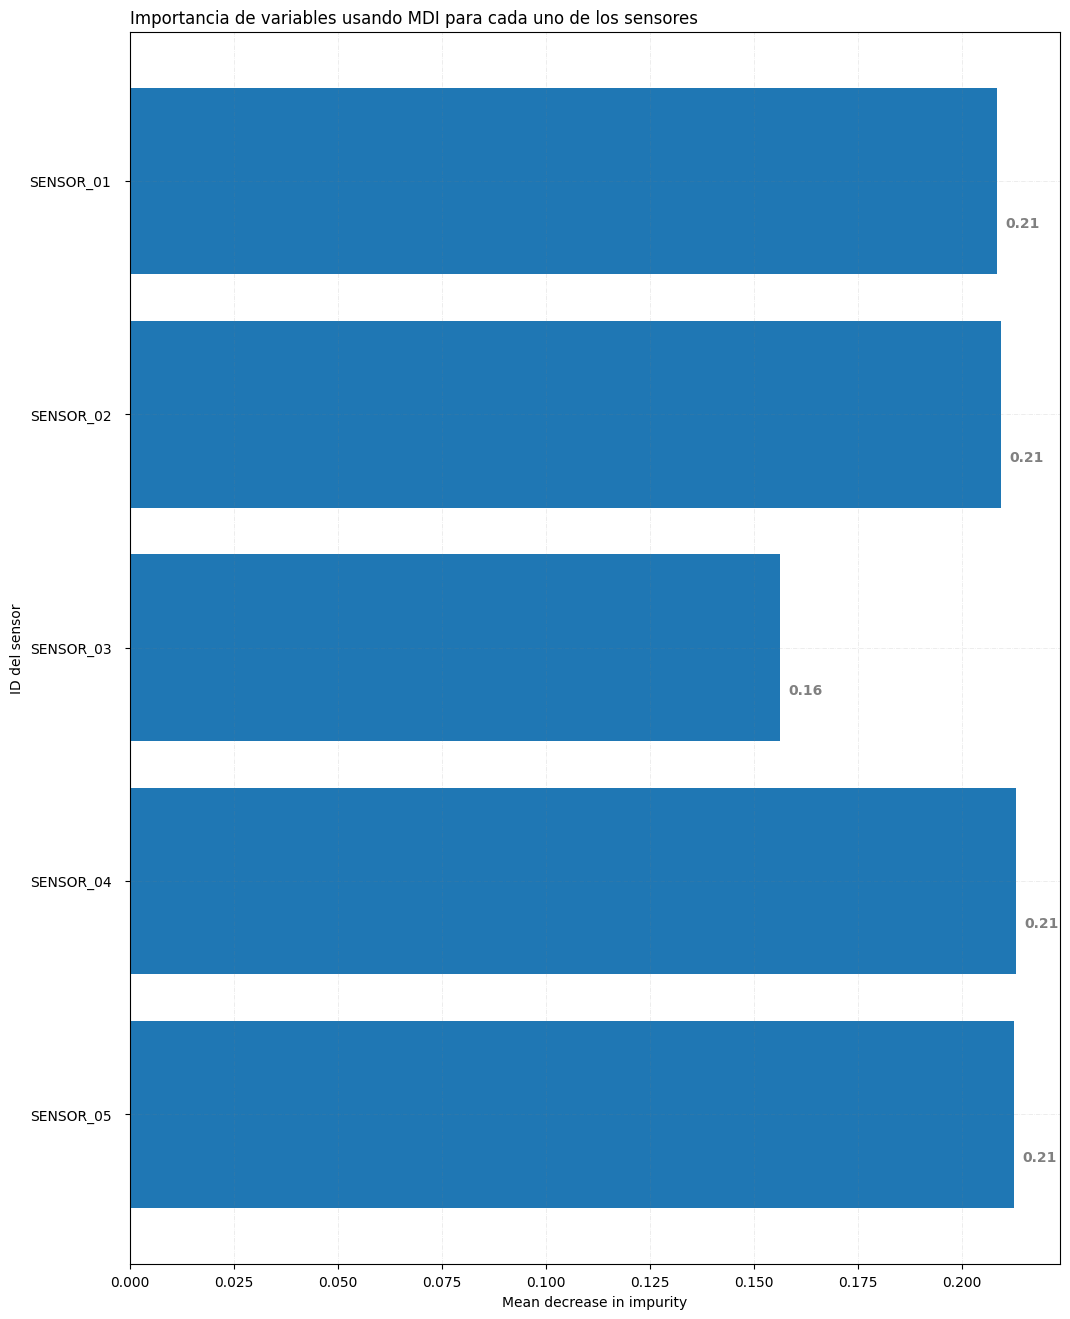

In [ ]:
barplotData = pd.DataFrame( np.zeros([len(sensorNames),2]) )
barplotData[0] = sensorNames
barplotData[1] = row_averages_RFMDI

# Figure Size
fig, ax = plt.subplots(figsize=(12, 16))

# Horizontal Bar Plot
plt.barh(barplotData[0], barplotData[1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

    currentOffset = 0.002
    currentW = i.get_width()
    if(currentW < 0): currentOffset = -0.005

    plt.text(i.get_width() + currentOffset, i.get_y() + 0.6,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Importancia de variables usando MDI para cada uno de los sensores',
             loc='left', )

ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("ID del sensor")

# Show Plot
plt.show()

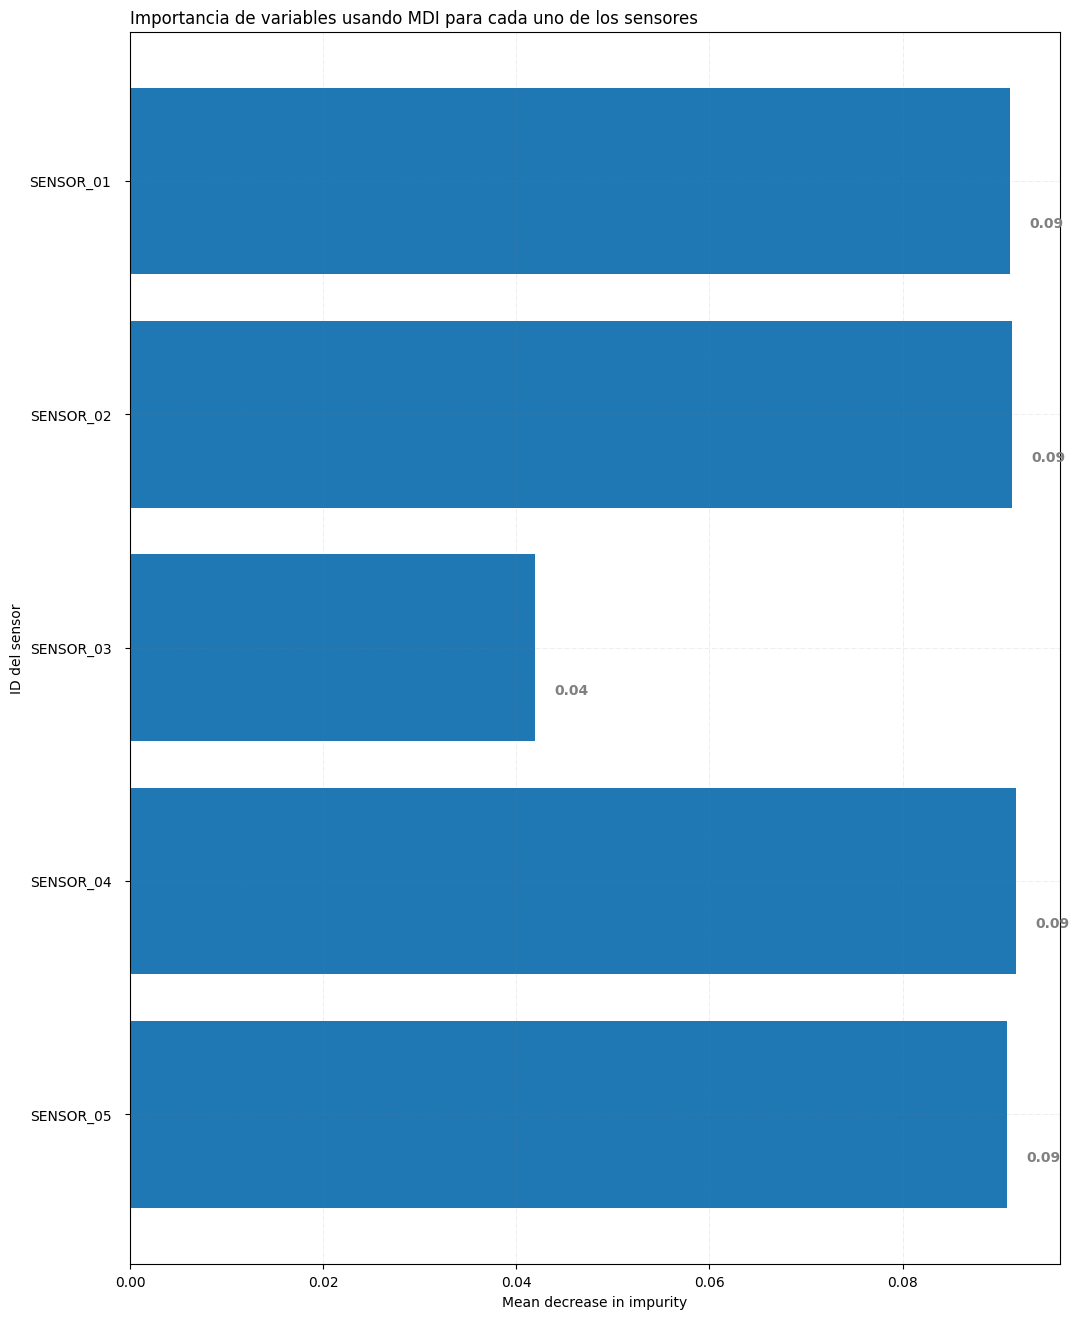

In [ ]:
barplotData = pd.DataFrame( np.zeros([len(sensorNames),2]) )
barplotData[0] = sensorNames
barplotData[1] = row_averages_RFSHAP

# Figure Size
fig, ax = plt.subplots(figsize=(12, 16))

# Horizontal Bar Plot
plt.barh(barplotData[0], barplotData[1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

    currentOffset = 0.002
    currentW = i.get_width()
    if(currentW < 0): currentOffset = -0.005

    plt.text(i.get_width() + currentOffset, i.get_y() + 0.6,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Importancia de variables usando MDI para cada uno de los sensores',
             loc='left', )

ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("ID del sensor")

# Show Plot
plt.show()

Guardamos los resultados

In [ ]:
# MDI
# Nombre del fichero y directorio donde se guarda
RFMDI_SHAPS             = 'RFMDI_Pesos_'            + str(TOTAL_FILES) + '.csv'
RFMDI_AVERAGE_VALUES    = 'RFMDI_averageValues_'    + str(TOTAL_FILES) + '.txt'

BASE_FOLDER = PROJECT_FOLDER + 'Resultados/Simulaciones/'

# Guardar el resultado para que luego se pueda hacer el heatmap
lista_de_medias_RFMDI.to_csv( BASE_FOLDER + RFMDI_SHAPS, index=False)
np.savetxt(BASE_FOLDER + RFMDI_AVERAGE_VALUES, row_averages_RFMDI)

# SHAP
# Nombre del fichero y directorio donde se guarda
RFSHAP_SHAPS             = 'RFSHAP_Pesos_'            + str(TOTAL_FILES) + '.csv'
RFSHAP_AVERAGE_VALUES    = 'RFSHAP_averageValues_'    + str(TOTAL_FILES) + '.txt'

BASE_FOLDER = PROJECT_FOLDER + 'Resultados/Simulaciones/'

# Guardar el resultado para que luego se pueda hacer el heatmap
lista_de_medias_RFSHAP.to_csv( BASE_FOLDER + RFSHAP_SHAPS, index=False)
np.savetxt(BASE_FOLDER + RFSHAP_AVERAGE_VALUES, row_averages_RFSHAP)


# Para ambos (sólo hay un modelo RF, pero varias formas MDI SHAP de medir los pesos)
RF_PREDICTION_VALUES    = 'RF_predictionValues_'    + str(TOTAL_FILES) + '.txt'
np.savetxt(BASE_FOLDER + RF_PREDICTION_VALUES, lista_de_RF_scores)

# Heatmap

In [ ]:
import matplotlib as mpl

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation = -90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    #plt.rcParams.update({'font.size': 15})

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)



    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:

# Hay que transformar los números en valor absoluto y normalizarlo entre 0 y 1
pesosAFRL = np.abs(row_averages_ANN)
pesosAFRL = pesosAFRL/pesosAFRL.max()

pesosANN = np.abs(row_averages_ANN)
pesosANN = pesosANN/pesosANN.max()

pesosPLS = np.abs(row_averages_PLS)
pesosPLS = pesosPLS/pesosPLS.max()

pesosKNN = np.abs(row_averages_KNN)
pesosKNN = pesosKNN/pesosKNN.max()

pesosRFM = np.abs(row_averages_RFMDI)
pesosRFM = pesosRFM/pesosRFM.max()

pesosRFS = np.abs(row_averages_RFSHAP)
pesosRFS = pesosRFS/pesosRFS.max()

In [ ]:
# Creamos el dataframe vacío donde guardamos las predicciones de cada modelo.
#
# El orden será
# ---- ANN
# ---- KNN
# ---- Random Forest (SHAP)
# ---- Random Forest (MDI)
# ---- PLS
# ---- AF-RL
shapAverageData    = pd.DataFrame(0, index=range( len(sensorNames) ), columns=range(6))
shapSigmaData      = pd.DataFrame(0, index=range( len(sensorNames) ), columns=range(6))
shapAbsAverageData = pd.DataFrame(0, index=range( len(sensorNames) ), columns=range(6))
shapAbsSigmaData   = pd.DataFrame(0, index=range( len(sensorNames) ), columns=range(6))


shapAverageData    = shapAverageData.set_axis(['ANN_SHAP', 'KNN_SHAP', 'RandomForest_SHAP', 'RandomForest_MDI', 'PLS', 'AF-RL'], axis=1)
shapSigmaData      = shapSigmaData.set_axis(['ANN_SHAP', 'KNN_SHAP', 'RandomForest_SHAP', 'RandomForest_MDI', 'PLS', 'AF-RL'], axis=1)
shapAbsAverageData = shapAbsAverageData.set_axis(['ANN_SHAP', 'KNN_SHAP', 'RandomForest_SHAP', 'RandomForest_MDI', 'PLS', 'AF-RL'], axis=1)
shapAbsSigmaData   = shapAbsSigmaData.set_axis(['ANN_SHAP', 'KNN_SHAP', 'RandomForest_SHAP', 'RandomForest_MDI', 'PLS', 'AF-RL'], axis=1)

In [ ]:
# Metemos los datos en el dataframe

# ---- 0 - ANN
shapAbsAverageData.iloc[:,0] = pesosANN

# ---- 1 - KNN
shapAbsAverageData.iloc[:,1] = pesosKNN

# ---- 2 - RF SHAP
shapAbsAverageData.iloc[:,2] = pesosRFS

# ---- 3 - RF MDI
shapAbsAverageData.iloc[:,3] = pesosRFM

# ---- 4 - PLS
shapAbsAverageData.iloc[:,4] = pesosPLS

# ---- 5 - AF-RL

# Creamos un vector donde almacenamos los valores de importancia
vectorMedias    = np.zeros(5)
vectorAbsMedias = pesosAFRL
vectorSigmas    = np.zeros(5)
vectorAbsSigmas = np.zeros(5)

# Lo metemos todo en la tabla final
shapAverageData.iloc[:,5]    = vectorMedias
shapSigmaData.iloc[:,5]      = vectorSigmas
shapAbsAverageData.iloc[:,5] = vectorAbsMedias
shapAbsSigmaData.iloc[:,5]   = vectorAbsSigmas

<ipython-input-29-465322236367>:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  shapAverageData.iloc[:,5]    = vectorMedias
<ipython-input-29-465322236367>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  shapSigmaData.iloc[:,5]      = vectorSigmas
<ipython-input-29-465322236367>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(

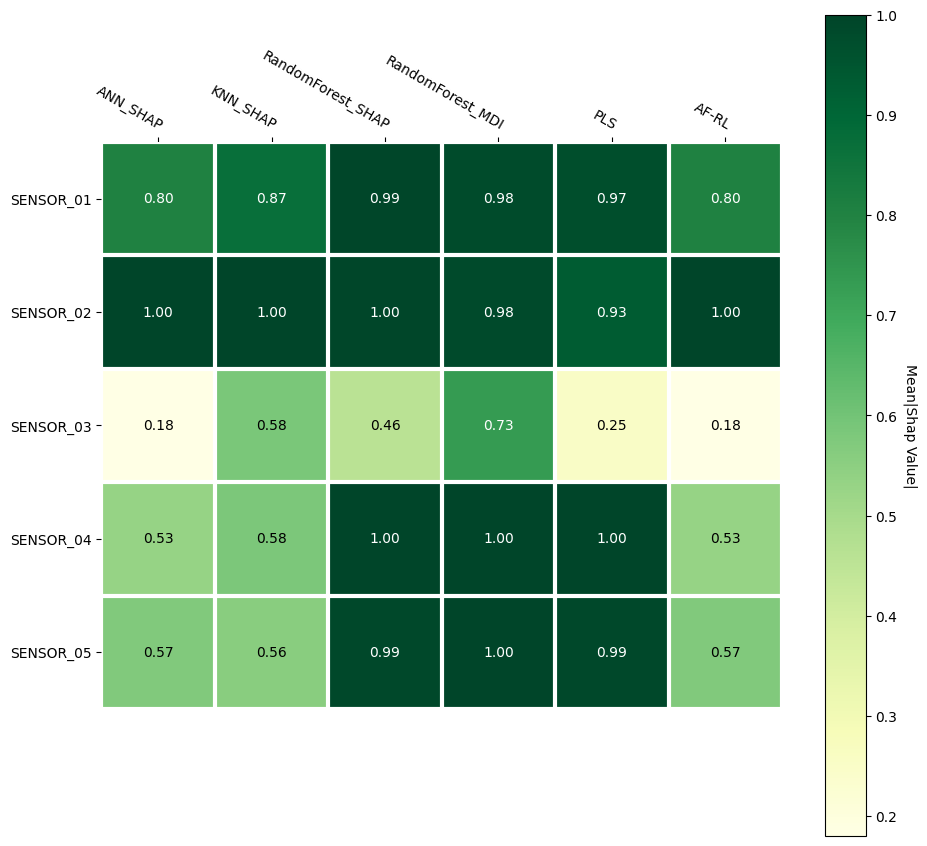

In [ ]:
# ----------------------------------
# OJO!
# No encuentro el fallo, pero la primera vez que se ejecuta este código, el
# gráfico sale bastante feo, pero si lo vuelves a ejecutar una segunda vez
# sale mucho mejor :-S
# ----------------------------------


# Show the SHAP heatmaps

# ----------------------------------
# Absolute
# ----------------------------------

# Prepare the data to do a heatmap of the normalzed SHAP values
heatmapDF = shapAbsAverageData.copy()

# Datos del heatmap
a = heatmapDF.to_numpy().astype(float)

# Nombre de cada una de las filas (sensores)
b = sensorNames

# Nombre de las columnas
c = heatmapDF.columns.values.tolist()


fig, ax = plt.subplots()

im, cbar = heatmap(a, b, c, ax=ax, cmap="YlGn", cbarlabel="Mean|Shap Value|")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
fig.set_size_inches(10.5, 10.5)
plt.rcParams.update({'font.size': 8})
plt.show()